In [1]:
# test of HMM
import numpy as np
import analysis

s = np.array([0, 0, 1, 0, 2, 2, 2])
n = 3
m = 4
seq = np.array(
    [
        [0, 1, 1, 1],
        [0, 0, 1, 0],
        [0, 0, 1, 0],
        [0, 1, 0, 0],
        [1, 0, 0, 1],
        [1, 1, 0, 0],
        [0, 1, 0, 1],
    ]
)

hmm = analysis.HMM4binary_sensors()
hmm.fit_with_true_hidden_states(seq, s)
print(hmm.predict_states(seq))
print(hmm.A)
print(hmm.P)

(array([0, 1, 0, 2, 2, 2, 2]), 5.873606637142921e-07)
[[0.33333333 0.33333333 0.33333333]
 [1.         0.         0.        ]
 [0.         0.         1.        ]]
[[0.         0.66666667 0.66666667 0.33333333]
 [0.         0.         1.         0.        ]
 [0.66666667 0.66666667 0.         0.66666667]]


In [3]:
import numpy as np
import analysis

C = np.array([1 / 2, 1 / 2])
A = np.array([[1 / 4, 3 / 4], [1 / 4, 3 / 4]])
P = np.array([[4 / 5, 1 / 5], [1 / 5, 2 / 3]])
s = np.random.randint(0, 2)
states = [s]
data = [[np.random.binomial(1, P[s][0]), np.random.binomial(1, P[s][1])]]
for i in range(10000):
    flag = np.random.binomial(1, A[s][0])
    if s == 0:
        if not (flag):
            s = 1
    else:
        if flag:
            s = 0
    states.append(s)
    data.append([np.random.binomial(1, P[s][0]), np.random.binomial(1, P[s][1])])
states = np.array(states)
data = np.array(data)

hmm = analysis.HMM4binary_sensors()
hmm.fit_with_true_hidden_states(data, states)
print(hmm.C)
print(hmm.A)
print(hmm.P)

[0. 1.]
[[0.25408204 0.74591796]
 [0.25023368 0.74976632]]
[[0.79299363 0.21218153]
 [0.20269729 0.67071705]]


In [148]:
# test of trajectory calculation

import math


def angle_cost(angle_diff):
    if angle_diff > 3 / 4 * math.pi:
        return 200
    elif angle_diff > math.pi / 4:
        return 75
    elif angle_diff > math.pi / 12:
        return (180 * angle_diff / math.pi) ** 2 / 45
    else:
        return (180 * angle_diff / math.pi) / 3


numpy_angle_cost = np.vectorize(angle_cost)

g_L, g_W = 5, 5
distance = np.arange(156).reshape((13, 12))
discomfort = np.arange(156).reshape((13, 12)) + 2
M, N = distance.shape
I, J = 6, 8

# print(cost.astype(np.int32))
max_ii, max_jj = 6, 6
min_ii, min_jj = 2, 2

start_i = max(0, I - max_ii + 1)
end_i = min(I + max_ii, M)
start_j = max(0, J - max_jj + 1)
end_j = min(J + max_jj, N)
print(f"start_i:{start_i}, end_i:{end_i}")
print(f"start_j:{start_j}, end_j:{end_j}")

m, n = end_i - start_i, end_j - start_j
print(f"m:{m}, n:{n}")

cost = np.full((m, n), 99999.0)
column_index, row_index = np.meshgrid(np.arange(n), np.arange(m))
row_index += start_i
column_index += start_j

mask = np.full((m, n), True)
mask[
    max(0, I - min_ii) - start_i : min(I + min_ii + 1, M) - start_i,
    max(0, J - min_jj) - start_j : min(J + min_jj + 1, N) - start_j,
] = False
print(mask)
# (1) weighted distance from the next position to the any points in the target area
cost[mask] = distance[row_index, column_index][mask]
print(cost.astype(np.int32))

# (2) weighted distance (with discomfort caused by nearby obstacles) from the position to the next position
_temp_row_index = I + (row_index - I) // 2
_temp_column_index = J + (column_index - J) // 2
discomfort_on_half_position = discomfort[_temp_row_index, _temp_column_index]
# approximate discomfort value between the present postion and the next postion
mean_discomfort = (
    discomfort[I][J] + discomfort[row_index, column_index] + discomfort_on_half_position
) / 3
length_matrix = np.sqrt(
    np.square((row_index - I) * g_L) + np.square((column_index - J) * g_W)
)
cost += mean_discomfort * length_matrix

# (3) discomfort caused by the resident changing his/her walking direction
if angle != None:
    radian = np.arctan2(column_index - J, row_index - I)
    diff = np.abs(radian - math.atan2(angle[1], angle[0]))
    acute_diff_angle = np.minimum(diff, 2 * math.pi - diff)
    cost += numpy_angle_cost(acute_diff_angle)

# (4) resident’s most suitable walking stride length
cost += np.square(length_matrix - stride) / 4

# (5) noise
cost += 2 * np.random.rand(m, n)

# select the next step
if np.min(cost) >= 99999:
    raise ValueError("Any position is not possible to move.")
print(cost.astype(np.int32))
min_index_2d = np.unravel_index(np.argmin(cost), cost.shape)
next_pos = (start_i + min_index_2d[0], start_j + min_index_2d[1])
II, JJ = next_pos[0] - I, next_pos[1] - J
print(II, JJ)
print(next_pos)

start_i:1, end_i:12
start_j:3, end_j:12
m:11, n:9
[[ True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True]
 [ True  True  True False False False False False  True]
 [ True  True  True False False False False False  True]
 [ True  True  True False False False False False  True]
 [ True  True  True False False False False False  True]
 [ True  True  True False False False False False  True]
 [ True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True]]
[[   15    16    17    18    19    20    21    22    23]
 [   27    28    29    30    31    32    33    34    35]
 [   39    40    41    42    43    44    45    46    47]
 [   51    52    53 99999 99999 99999 99999 99999    59]
 [   63    64    65 99999 99999 99999 99999 99999    71]
 [   75    76    77 99999 99999 99999

In [147]:
import math


def angle_cost(angle_diff):
    if angle_diff > 3 / 4 * math.pi:
        return 200
    elif angle_diff > math.pi / 4:
        return 75
    elif angle_diff > math.pi / 12:
        return (180 * angle_diff / math.pi) ** 2 / 45
    else:
        return (180 * angle_diff / math.pi) / 3


numpy_angle_cost = np.vectorize(angle_cost)
cost = np.full((M, N), 99999.0)
g_L, g_W = 5, 5
distance = np.arange(156).reshape((13, 12))
discomfort = np.arange(156).reshape((13, 12)) + 2
M, N = distance.shape
I, J = 6, 8

# print(cost.astype(np.int32))
max_ii, max_jj = 6, 6
min_ii, min_jj = 2, 2

mask = np.full((M, N), False)
mask[
    max(0, I - max_ii + 1) : min(I + max_ii, M),
    max(0, J - max_jj + 1) : min(J + max_jj, N),
] = True
mask[
    max(0, I - min_ii) : min(I + min_ii + 1, M),
    max(0, J - min_jj) : min(J + min_jj + 1, N),
] = False
cost[mask] = distance[mask]
print(cost.astype(np.int32))

# (2) weighted distance (with discomfort caused by nearby obstacles) from the position to the next position
column_index, row_index = np.meshgrid(np.arange(N), np.arange(M))
_temp_row_index = I + (row_index - I) // 2
_temp_column_index = J + (column_index - J) // 2
discomfort_on_half_position = discomfort[_temp_row_index, _temp_column_index]
# approximate discomfort value between the present postion and the next postion
mean_discomfort = (discomfort[I][J] + discomfort + discomfort_on_half_position) / 3
length_matrix = np.sqrt(
    np.square((row_index - I) * g_L) + np.square((column_index - J) * g_W)
)
cost += mean_discomfort * length_matrix

angle = (1, 1)
stride = 20
# (3) discomfort caused by the resident changing his/her walking direction
if angle != None:
    radian = np.arctan2(column_index - J, row_index - I)
    diff = np.abs(radian - math.atan2(angle[1], angle[0]))
    acute_diff_angle = np.minimum(diff, 2 * math.pi - diff)
    cost += numpy_angle_cost(acute_diff_angle)

# (4) resident’s most suitable walking stride length
cost += np.square(length_matrix - stride) / 4

# (5) noise
cost += 2 * np.random.rand(M, N)

print(discomfort)
print(discomfort_on_half_position)
print(length_matrix.astype(np.int32))
print(numpy_angle_cost(acute_diff_angle).astype(np.int32))
print((np.square(length_matrix - stride) / 4).astype(np.int32))

[[99999 99999 99999 99999 99999 99999 99999 99999 99999 99999 99999 99999]
 [99999 99999 99999    15    16    17    18    19    20    21    22    23]
 [99999 99999 99999    27    28    29    30    31    32    33    34    35]
 [99999 99999 99999    39    40    41    42    43    44    45    46    47]
 [99999 99999 99999    51    52    53 99999 99999 99999 99999 99999    59]
 [99999 99999 99999    63    64    65 99999 99999 99999 99999 99999    71]
 [99999 99999 99999    75    76    77 99999 99999 99999 99999 99999    83]
 [99999 99999 99999    87    88    89 99999 99999 99999 99999 99999    95]
 [99999 99999 99999    99   100   101 99999 99999 99999 99999 99999   107]
 [99999 99999 99999   111   112   113   114   115   116   117   118   119]
 [99999 99999 99999   123   124   125   126   127   128   129   130   131]
 [99999 99999 99999   135   136   137   138   139   140   141   142   143]
 [99999 99999 99999 99999 99999 99999 99999 99999 99999 99999 99999 99999]]
[[  2   3   4   5   6   

In [ ]:
mat = np.zeros((10, 5))
mat[1, 0] = 1
mat[4, 3] = 1
mat[4, 4] = 1
mat[5, 1] = 1
nrt, valid_sensor_ids = analysis.nonresponse_time_sliding(mat, [], 1, 5, _type = "max_time")
print(mat)
print()
print(nrt)

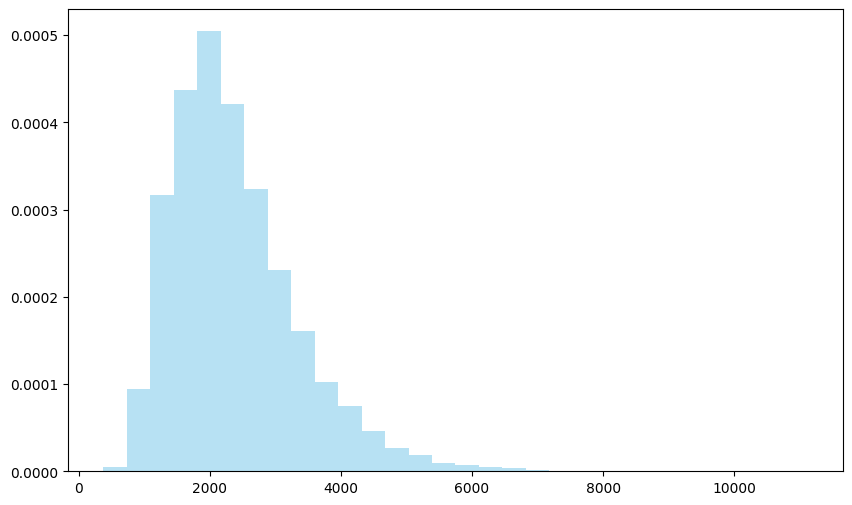

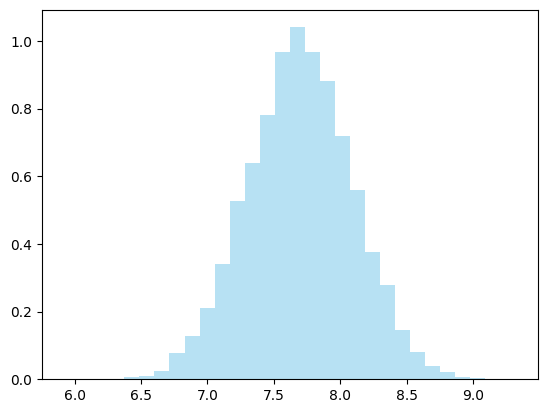

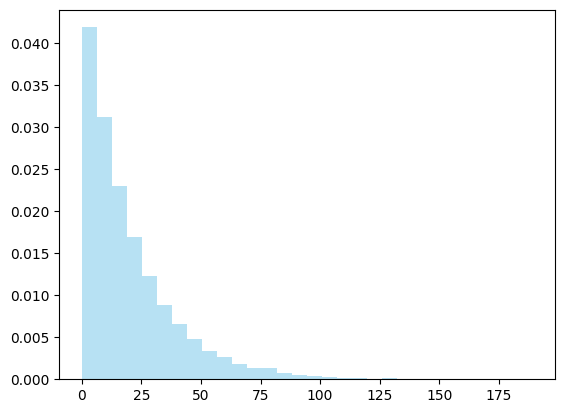

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import src.sensor_model as sensor_model

# パラメータを設定
mean = 60*40
std = 1000
size = 10000

# 対数正規分布の乱数を生成
data = np.array([sensor_model.CircularPIRSensor.duration_time_in_activity(mean, std) for _ in range(size)])
data2 = np.log(data)

mean_interval = 20
data3 = np.array([sensor_model.CircularPIRSensor.interval_time_in_activity(mean_interval) for _ in range(size)])

# ヒストグラムを描画
plt.figure(figsize=(10, 6))
plt.hist(data, bins=30, density=True, alpha=0.6, color='skyblue', label='Histogram')
plt.show()
plt.close()

plt.hist(data2, bins=30, density=True, alpha=0.6, color='skyblue', label='Histogram')
plt.show()
plt.close()

plt.hist(data3, bins=30, density=True, alpha=0.6, color='skyblue', label='Histogram')
plt.show()
plt.close()


In [3]:
from pathlib import Path
import src.floor_plan as floor_plan
import src.utils as utils
layout_path = Path("./layout_data/test_layout")

FP = floor_plan.FloorPlan()
FP.load_layout(layout_path)

centers = utils.place_centers_dict(FP)
for key, value in centers.items():
    print(key, value)

Bed [(-115.0, 105.0)]
Wardrobe [(-130.0, -135.0)]
Desk [(65.0, -140.0)]
Desk_Chair [(120.0, -140.0)]
Kitchen_Stove [(980.0, 120.0)]
Cupboard [(745.0, -30.0)]
Refrigerator [(860.0, -60.0)]
Wash_Machine [(860.0, 180.0)]
Trash_Bin [(735.0, 180.0)]
Sofa [(320.0, -50.0)]
TV [(320.0, 190.0)]
Dinner_Table [(555.0, 150.0)]
Dinner_Table_Chair [(625.0, 150.0), (555.0, 60.0)]
Entrance [(190.0, 210.0)]
Toilet_Door [(465.0, -210.0)]
Bathroom_Door [(600.0, -210.0)]
Toilet [(465.0, -270.0)]
Bathroom [(600.0, -270.0)]
